# Wavelet Transform Coefficient Preprocessing

In [1]:
%load_ext autoreload
%autoreload 2
p = print

import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from scipy.fftpack import fft, fftfreq, fftshift
from scipy import signal
import pywt

from crypr.util import get_project_path
from crypr.build import make_single_feature, data_to_supervised

In [2]:
SYM = 'BTC'
TARGET = 'close'
Tx = 72
Ty = 1
TEST_SIZE = 0.05

data_path = os.path.join(get_project_path(), 'data', 'raw', SYM + '.csv')

data = pd.read_csv(data_path, index_col=0)
data.head()

,volumeto,volumefrom,open,high,close,low,time,timestamp
0,6935520.93,1096.93,6314.14,6322.24,6313.66,6290.84,1530471600,2018-07-01 21:00:00
1,24714923.33,3879.19,6313.94,6378.28,6347.37,6298.49,1530475200,2018-07-01 22:00:00
2,9517750.88,1496.49,6347.37,6359.64,6355.81,6331.35,1530478800,2018-07-01 23:00:00
3,12533312.19,1965.11,6355.81,6371.16,6355.41,6346.47,1530482400,2018-07-02 00:00:00
4,13213908.33,2074.03,6355.41,6371.17,6339.04,6337.97,1530486000,2018-07-02 01:00:00


In [3]:
"""
Get percent change feature and target data.
"""
df = make_single_feature(input_df=data, target_col='close')
p(df.head())
X, y = data_to_supervised(input_df=df[['target']], Tx=Tx, Ty=Ty)
p(X.shape, y.shape)
X.head()

     close    target
1  6347.37  0.533922
2  6355.81  0.132968
3  6355.41 -0.006293
4  6339.04 -0.257576
5  6334.51 -0.071462
(5926, 72) (5926, 1)


,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
73,0.533922,0.132968,-0.006293,-0.257576,-0.071462,-0.155813,0.055023,-0.061788,-0.311818,-0.264097,...,-0.196975,0.217484,0.336705,2.567298,-0.246313,-0.245727,-0.215353,0.153127,-0.045374,0.192814
74,0.132968,-0.006293,-0.257576,-0.071462,-0.155813,0.055023,-0.061788,-0.311818,-0.264097,0.299149,...,0.217484,0.336705,2.567298,-0.246313,-0.245727,-0.215353,0.153127,-0.045374,0.192814,0.082988
75,-0.006293,-0.257576,-0.071462,-0.155813,0.055023,-0.061788,-0.311818,-0.264097,0.299149,0.360255,...,0.336705,2.567298,-0.246313,-0.245727,-0.215353,0.153127,-0.045374,0.192814,0.082988,0.012550
76,-0.257576,-0.071462,-0.155813,0.055023,-0.061788,-0.311818,-0.264097,0.299149,0.360255,-0.052612,...,2.567298,-0.246313,-0.245727,-0.215353,0.153127,-0.045374,0.192814,0.082988,0.012550,-1.429769
77,-0.071462,-0.155813,0.055023,-0.061788,-0.311818,-0.264097,0.299149,0.360255,-0.052612,-0.118716,...,-0.246313,-0.245727,-0.215353,0.153127,-0.045374,0.192814,0.082988,0.012550,-1.429769,-0.126092


In [4]:
"""
Confirm data reshape and target/feature creation was done correctly.
"""
y_values_except_last = np.squeeze(y.iloc[:-1].values)
t_minus_1_x_values_except_first = X.iloc[1:,-1].values

y_values_except_last.all() == t_minus_1_x_values_except_first.all()

True

In [5]:
"""
For comparing different transformations
"""
sample_ix = 1000

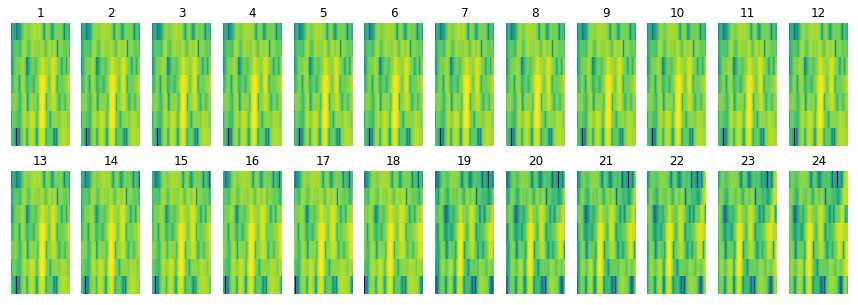

In [6]:
"""
Spectrogram Analysis
"""
rows = 2
cols = 12

fig, ax = plt.subplots(rows,cols, figsize=(15,5))

for r in range(rows):
    for c in range(cols):
        plt.sca(ax[r][c])
        pxx, freqs, bins, im = plt.specgram(X.iloc[(sample_ix + r*c)], 12, 1, noverlap=11)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.title((c + 1) + r*cols)
sns.despine(left=True, bottom=True)
plt.show()

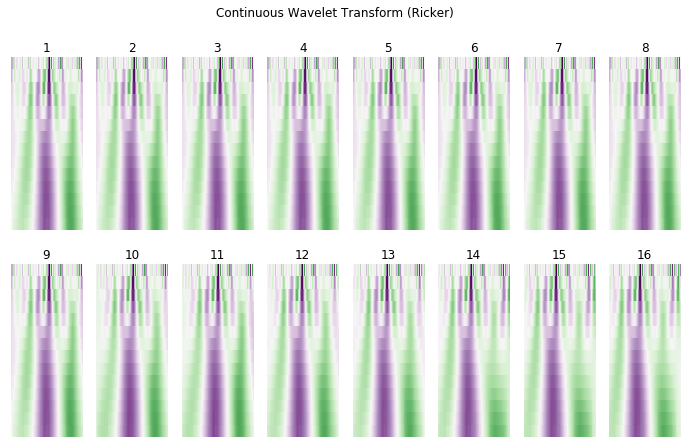

In [7]:
"""
CWT Ricker
"""
N = 14
# T = 1.0 / N
# START=1000
widths = np.arange(1, (N + 1))

rows = 2
cols = 8
fig, ax = plt.subplots(rows, cols, figsize=(12, 7))
for r in range(rows):
    for c in range(cols):
        plt.sca(ax[r][c])
        cwtmatr = signal.cwt(X.iloc[(sample_ix + r*c)], wavelet=signal.ricker, widths=widths)
        plt.imshow(cwtmatr, extent=[-1, 1, 1, (N + 1)], cmap='PRGn', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.title((c + 1) + r*cols)
sns.despine(left=True, bottom=True)
plt.suptitle('Continuous Wavelet Transform (Ricker)')
plt.show() 

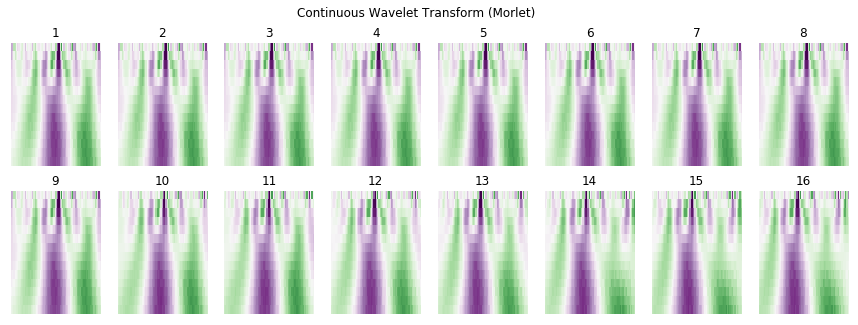

In [8]:
"""
CWT Morlet Transform
"""

rows = 2
cols = 8

fig, ax = plt.subplots(rows,cols, figsize=(15,5))

for r in range(rows):
    for c in range(cols):
        plt.sca(ax[r][c])
        cwtmatr, freqs = pywt.cwt(X.iloc[(sample_ix + r*c)], scales=widths, wavelet='mexh')
        plt.imshow(cwtmatr, extent=[-1, 1, 1, (N + 1)], cmap='PRGn', aspect='auto',
                   vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.title((c + 1) + r*cols)
sns.despine(left=True, bottom=True)
plt.suptitle('Continuous Wavelet Transform (Morlet)')
plt.show() 

In [9]:
"""
Apply the wave transformation to the feature data.
"""
wt_type = 'MORLET'
p('Applying {} transform ...'.format(wt_type))
N = 28
widths = np.arange(1, (N + 1))

if wt_type == 'RICKER':
    wt_transform_fun = lambda x: signal.cwt(x, wavelet=signal.ricker, widths=widths)
elif wt_type == 'MORLET':
    wt_transform_fun = lambda x: pywt.cwt(x, scales=widths, wavelet='morl')[0]
else:
    raise NotImplementedError
    
X_wt_coef = np.apply_along_axis(func1d=wt_transform_fun, axis=-1, arr=X)

p('Old shape: ', X.shape)
p('New shape: ', X_wt_coef.shape)

Applying MORLET transform ...
Old shape:  (5926, 72)
New shape:  (5926, 28, 72)


In [10]:
"""
Train Test Split.
"""
X_train, X_test, y_train, y_test = train_test_split(X_wt_coef, y, test_size=TEST_SIZE, shuffle=False)

In [11]:
"""
Save data.
"""
output_dir = os.path.join(get_project_path(), 'data', 'processed')

np.save(arr=X_train, allow_pickle=True, 
        file=os.path.join(output_dir, 'X_train_{}_{}_{}x{}'.format(SYM, wt_type, N, Tx)))
np.save(arr=X_test, allow_pickle=True,
        file=os.path.join(output_dir, 'X_test_{}_{}_{}x{}'.format(SYM, wt_type, N, Tx)))
np.save(arr=y_train, allow_pickle=True,
        file=os.path.join(output_dir, 'y_train_{}_{}_{}x{}'.format(SYM, wt_type, N, Tx)))
np.save(arr=y_test, allow_pickle=True,
        file=os.path.join(output_dir, 'y_test_{}_{}_{}x{}'.format(SYM, wt_type, N, Tx)))